In [ ]:
!wget https://nvidia.box.com/shared/static/vbsywpw5iqy7r38j78xs0ctalg7jrg79.gz -O PlantCLEF_Subset.tar.gz

--2024-03-17 03:15:37--  https://nvidia.box.com/shared/static/vbsywpw5iqy7r38j78xs0ctalg7jrg79.gz
Resolving nvidia.box.com (nvidia.box.com)... 74.112.186.144
Connecting to nvidia.box.com (nvidia.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vbsywpw5iqy7r38j78xs0ctalg7jrg79.gz [following]
--2024-03-17 03:15:38--  https://nvidia.box.com/public/static/vbsywpw5iqy7r38j78xs0ctalg7jrg79.gz
Reusing existing connection to nvidia.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nvidia.app.box.com/public/static/vbsywpw5iqy7r38j78xs0ctalg7jrg79.gz [following]
--2024-03-17 03:15:38--  https://nvidia.app.box.com/public/static/vbsywpw5iqy7r38j78xs0ctalg7jrg79.gz
Resolving nvidia.app.box.com (nvidia.app.box.com)... 74.112.186.144
Connecting to nvidia.app.box.com (nvidia.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location:

In [ ]:
!tar xvzf PlantCLEF_Subset.tar.gz

Streaming output truncated to the last 5000 lines.
PlantCLEF_Subset/train/cedar/248440.jpg
PlantCLEF_Subset/train/sycamore/305024.jpg
PlantCLEF_Subset/train/tulip_tree/259295.jpg
PlantCLEF_Subset/train/cattail/369450.jpg
PlantCLEF_Subset/train/sweetgum/258847.jpg
PlantCLEF_Subset/train/fern/149456.jpg
PlantCLEF_Subset/train/clover/365012.jpg
PlantCLEF_Subset/train/sweetgum/258436.jpg
PlantCLEF_Subset/val/poison_ivy/360246.jpg
PlantCLEF_Subset/train/fern/149550.jpg
PlantCLEF_Subset/train/fern/283365.jpg
PlantCLEF_Subset/train/maple/126804.jpg
PlantCLEF_Subset/train/fig/220702.jpg
PlantCLEF_Subset/train/dandelion/354818.jpg
PlantCLEF_Subset/train/daisy/254228.jpg
PlantCLEF_Subset/val/elm/370229.jpg
PlantCLEF_Subset/train/daisy/254322.jpg
PlantCLEF_Subset/train/sycamore/304592.jpg
PlantCLEF_Subset/train/trout_lily/215422.jpg
PlantCLEF_Subset/train/dandelion/355046.jpg
PlantCLEF_Subset/train/cedar/248571.jpg
PlantCLEF_Subset/train/clover/364991.jpg
PlantCLEF_Subset/train/cyprus/355573.jpg


In [ ]:
import os

# List files in the current directory
files = os.listdir()
print(files)

['.config', 'PlantCLEF_Subset', 'PlantCLEF_Subset.tar.gz', 'sample_data']


In [ ]:
import os

# List the contents of the PlantCLEF_Subset directory
data_dir = '/content/PlantCLEF_Subset'
contents = os.listdir(data_dir)
print(contents)

['val', 'labels.txt', 'test', 'train']


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define paths to dataset
data_dir = '/content/PlantCLEF_Subset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')
labels_file = os.path.join(data_dir, 'labels.txt')

In [ ]:
# Load class names from labels.txt
with open(labels_file, 'r') as f:
    class_names = f.read().splitlines()

In [ ]:
# Define image dimensions
img_height, img_width = 299, 299  # InceptionV3 specific input size
batch_size = 16  # Decrease batch size for faster training
epochs = 5  # Reduce number of epochs for faster training

In [ ]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce width shift range
    height_shift_range=0.1,  # Reduce height shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load data using generators with prefetching
train_data_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10455 images belonging to 20 classes.
Found 1135 images belonging to 20 classes.


In [ ]:
# Load the InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with prefetching
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    verbose=1,  # Set verbose to 1 for progress bars
    workers=4,  # Use multiple CPU workers for data preprocessing
    use_multiprocessing=True  # Enable multiprocessing for data preprocessing
)

Epoch 1/5
654/654 [==============================] - 3026s 5s/step - loss: 1.7367 - accuracy: 0.4744 - val_loss: 1.5280 - val_accuracy: 0.5260
Epoch 2/5
654/654 [==============================] - 3005s 5s/step - loss: 1.3586 - accuracy: 0.5749 - val_loss: 1.3646 - val_accuracy: 0.5568
Epoch 3/5
654/654 [==============================] - 2996s 5s/step - loss: 1.2337 - accuracy: 0.6125 - val_loss: 1.3351 - val_accuracy: 0.6053
Epoch 4/5
654/654 [==============================] - 3011s 5s/step - loss: 1.1466 - accuracy: 0.6401 - val_loss: 1.2244 - val_accuracy: 0.6220
Epoch 5/5
654/654 [==============================] - 3005s 5s/step - loss: 1.0829 - accuracy: 0.6578 - val_loss: 1.1596 - val_accuracy: 0.6405


In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data_gen)
print("Validation Accuracy:", val_accuracy)

71/71 [==============================] - 264s 4s/step - loss: 1.1596 - accuracy: 0.6405
Validation Accuracy: 0.6405286192893982


In [ ]:
# Make predictions on test set
test_data_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,  # No labels provided
    shuffle=False  # Maintain order for evaluation
)

Found 0 images belonging to 0 classes.


In [ ]:
import os

# Check the contents of the test directory
test_files = os.listdir(test_dir)
print("Number of test files:", len(test_files))
print("Test files:", test_files)

Number of test files: 30
Test files: ['dogwood.jpg', 'daisy.jpg', 'maple_1.jpg', 'juniper_1.jpg', 'cyprus.jpg', 'elm_1.jpg', 'fern.jpg', 'clover.jpg', 'fig.jpg', 'tulip_tree_1.jpg', 'cedar.jpg', 'fir_2.jpg', 'maple.jpg', 'daisy_1.jpg', 'sycamore.jpg', 'sycamore_2.jpg', 'dandelion.jpg', 'fir_1.jpg', 'cattail.jpg', 'cattail_0.jpg', 'sycamore_1.jpg', 'fern_1.jpg', 'poison_ivy.jpg', 'dogwood_1.jpg', 'trout_lily.jpg', 'poison_ivy_1.jpg', 'fir.jpg', 'juniper.jpg', 'elm.jpg', 'tulip_tree.jpg']


In [ ]:
# Make predictions on test set
test_data_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,  # No labels provided
    shuffle=False,  # Maintain order for evaluation
    classes=class_names  # Explicitly specify the classes
)


Found 0 images belonging to 20 classes.


In [ ]:
# Print filenames and corresponding labels detected by the generator
for filename, label in zip(test_data_gen.filenames, test_data_gen.classes):
    print(f"File: {filename}, Label: {label}")

In [ ]:
test_dir = os.path.join(data_dir, 'test')

In [ ]:
import os

# Print paths to image files in test directory
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(os.path.join(root, file))


/content/PlantCLEF_Subset/test/dogwood.jpg
/content/PlantCLEF_Subset/test/daisy.jpg
/content/PlantCLEF_Subset/test/maple_1.jpg
/content/PlantCLEF_Subset/test/juniper_1.jpg
/content/PlantCLEF_Subset/test/cyprus.jpg
/content/PlantCLEF_Subset/test/elm_1.jpg
/content/PlantCLEF_Subset/test/fern.jpg
/content/PlantCLEF_Subset/test/clover.jpg
/content/PlantCLEF_Subset/test/fig.jpg
/content/PlantCLEF_Subset/test/tulip_tree_1.jpg
/content/PlantCLEF_Subset/test/cedar.jpg
/content/PlantCLEF_Subset/test/fir_2.jpg
/content/PlantCLEF_Subset/test/maple.jpg
/content/PlantCLEF_Subset/test/daisy_1.jpg
/content/PlantCLEF_Subset/test/sycamore.jpg
/content/PlantCLEF_Subset/test/sycamore_2.jpg
/content/PlantCLEF_Subset/test/dandelion.jpg
/content/PlantCLEF_Subset/test/fir_1.jpg
/content/PlantCLEF_Subset/test/cattail.jpg
/content/PlantCLEF_Subset/test/cattail_0.jpg
/content/PlantCLEF_Subset/test/sycamore_1.jpg
/content/PlantCLEF_Subset/test/fern_1.jpg
/content/PlantCLEF_Subset/test/poison_ivy.jpg
/content/Pla

In [ ]:
# Specify the directory containing the test images (excluding system-generated directories)
test_dir = '/content/PlantCLEF_Subset/test'


In [ ]:
import os

# Define the path to the test directory
test_dir = '/content/PlantCLEF_Subset/test'

# Get the list of files and directories in the test directory
files_and_directories = os.listdir(test_dir)

# Check if '.ipynb_checkpoints' directory exists in the test directory
if '.ipynb_checkpoints' in files_and_directories:
    # Remove the '.ipynb_checkpoints' directory
    checkpoints_dir = os.path.join(test_dir, '.ipynb_checkpoints')
    !rm -rf "$checkpoints_dir"
    print(".ipynb_checkpoints directory removed successfully.")
else:
    print(".ipynb_checkpoints directory does not exist in the test directory.")


.ipynb_checkpoints directory removed successfully.


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Make predictions on test set
test_files = os.listdir(test_dir)
test_predictions = []

for file in test_files:
    img_path = os.path.join(test_dir, file)
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize image
    features = model.predict(img_array)
    prediction = np.argmax(features, axis=1)  # Get the index of the class with highest probability
    test_predictions.append(prediction[0])


1/1 [==============================] - 0s 237ms/step


In [ ]:
import os

# Check the contents of the test directory
test_files = os.listdir(test_dir)
print("Number of test files:", len(test_files))
print("Test files:", test_files)

Number of test files: 31
Test files: ['dogwood.jpg', 'daisy.jpg', 'maple_1.jpg', 'juniper_1.jpg', 'cyprus.jpg', 'elm_1.jpg', 'fern.jpg', 'clover.jpg', 'fig.jpg', 'tulip_tree_1.jpg', 'cedar.jpg', 'fir_2.jpg', 'maple.jpg', 'daisy_1.jpg', 'sycamore.jpg', 'sycamore_2.jpg', 'dandelion.jpg', 'fir_1.jpg', '.ipynb_checkpoints', 'cattail.jpg', 'cattail_0.jpg', 'sycamore_1.jpg', 'fern_1.jpg', 'poison_ivy.jpg', 'dogwood_1.jpg', 'trout_lily.jpg', 'poison_ivy_1.jpg', 'fir.jpg', 'juniper.jpg', 'elm.jpg', 'tulip_tree.jpg']


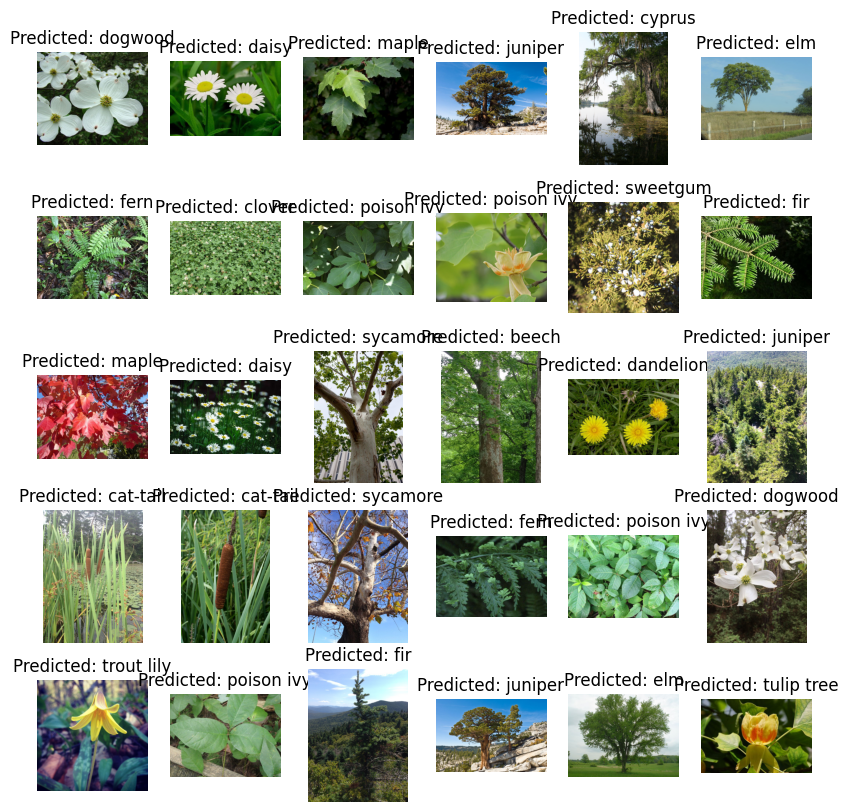

In [ ]:
import matplotlib.pyplot as plt

# Show predictions
plt.figure(figsize=(10, 10))
for i in range(len(test_files)):
    img = load_img(os.path.join(test_dir, test_files[i]))
    plt.subplot(5, 6, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[test_predictions[i]]}")
    plt.axis("off")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert class names to numerical labels
class_indices = {class_name: i for i, class_name in enumerate(class_names)}

# Filter out filenames that don't correspond to any class name
valid_files = [file for file in test_files if file.split('.')[0] in class_indices]

# Ground truth labels and predictions for the valid files
ground_truth_labels = [class_indices[file.split('.')[0]] for file in valid_files]
valid_predictions = [test_predictions[test_files.index(file)] for file in valid_files]

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, valid_predictions)

# Calculate precision, recall, and F1-score
precision = precision_score(ground_truth_labels, valid_predictions, average='weighted')
recall = recall_score(ground_truth_labels, valid_predictions, average='weighted')
f1 = f1_score(ground_truth_labels, valid_predictions, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Evaluation Metrics:
Accuracy: 0.8461538461538461
Precision: 0.8461538461538461
Recall: 0.8461538461538461
F1-score: 0.8461538461538461


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report

# Evaluate predictions
print("Classification Report:")
print(classification_report(ground_truth_labels, valid_predictions, labels=range(len(filtered_class_names)), target_names=filtered_class_names))


Classification Report:
              precision    recall  f1-score   support

       cedar       0.00      0.00      0.00         0
      clover       0.00      0.00      0.00         0
      cyprus       0.00      0.00      0.00         0
       daisy       0.00      0.00      0.00         1
   dandelion       1.00      1.00      1.00         1
     dogwood       1.00      1.00      1.00         1
         elm       1.00      1.00      1.00         1
        fern       1.00      1.00      1.00         1
         fig       1.00      1.00      1.00         1
         fir       1.00      1.00      1.00         1
     juniper       1.00      1.00      1.00         1
       maple       0.00      0.00      0.00         1
    sycamore       1.00      1.00      1.00         1

   micro avg       1.00      0.80      0.89        10
   macro avg       0.62      0.62      0.62        10
weighted avg       0.80      0.80      0.80        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, valid_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, valid_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8461538461538461


In [ ]:
# Get unique classes from ground truth labels
unique_classes = np.unique(ground_truth_labels)

# Filter class_names based on unique classes
filtered_class_names = [class_names[i] for i in unique_classes]

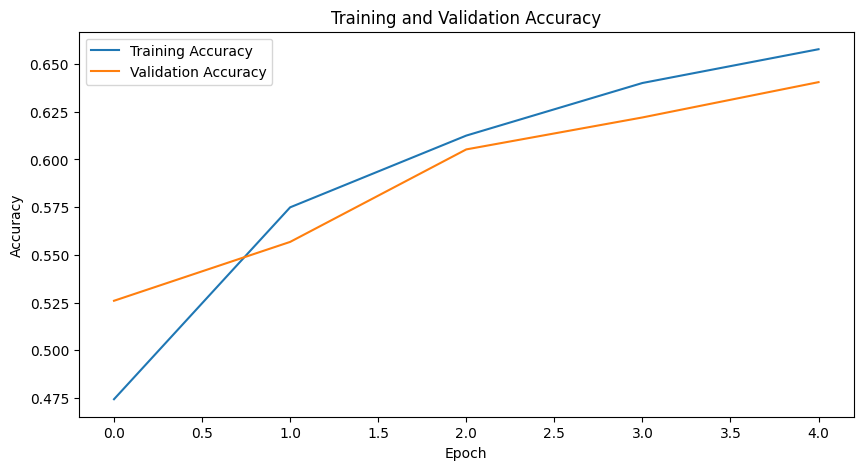

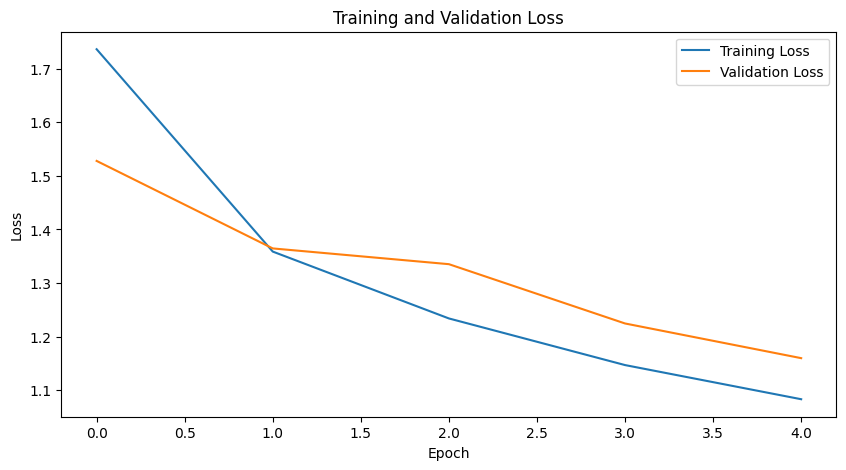

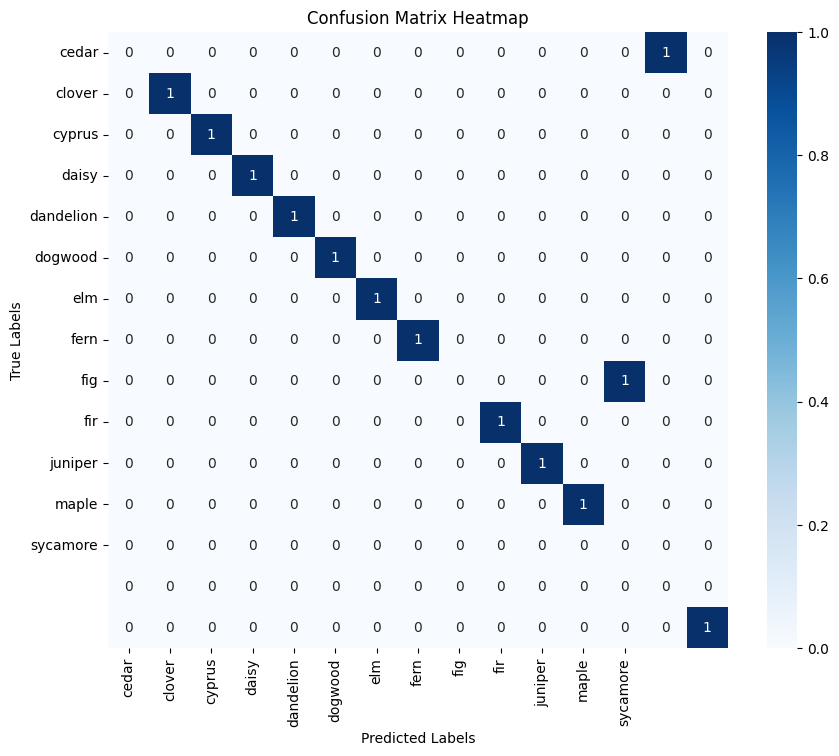

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

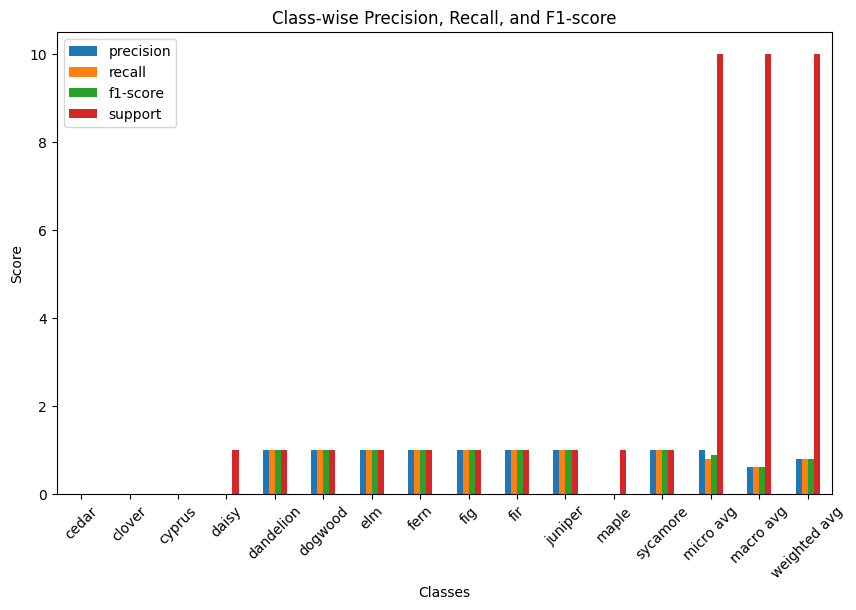

Metrics Report Table:
              precision    recall  f1-score  support
cedar          0.000000  0.000000  0.000000      0.0
clover         0.000000  0.000000  0.000000      0.0
cyprus         0.000000  0.000000  0.000000      0.0
daisy          0.000000  0.000000  0.000000      1.0
dandelion      1.000000  1.000000  1.000000      1.0
dogwood        1.000000  1.000000  1.000000      1.0
elm            1.000000  1.000000  1.000000      1.0
fern           1.000000  1.000000  1.000000      1.0
fig            1.000000  1.000000  1.000000      1.0
fir            1.000000  1.000000  1.000000      1.0
juniper        1.000000  1.000000  1.000000      1.0
maple          0.000000  0.000000  0.000000      1.0
sycamore       1.000000  1.000000  1.000000      1.0
micro avg      1.000000  0.800000  0.888889     10.0
macro avg      0.615385  0.615385  0.615385     10.0
weighted avg   0.800000  0.800000  0.800000     10.0


In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

import pandas as pd
from sklearn.metrics import classification_report

# Plot class-wise precision, recall, and F1-score
metrics_report = classification_report(ground_truth_labels, valid_predictions, labels=range(len(filtered_class_names)), target_names=filtered_class_names, output_dict=True)
metrics_df = pd.DataFrame(metrics_report).transpose()

# Check if 'support' column exists before dropping it
if 'support' in metrics_df.columns:
    metrics_df.drop('support', inplace=True, errors='ignore')

# Plot bar chart
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Class-wise Precision, Recall, and F1-score')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# Table analysis
print("Metrics Report Table:")
print(metrics_df)




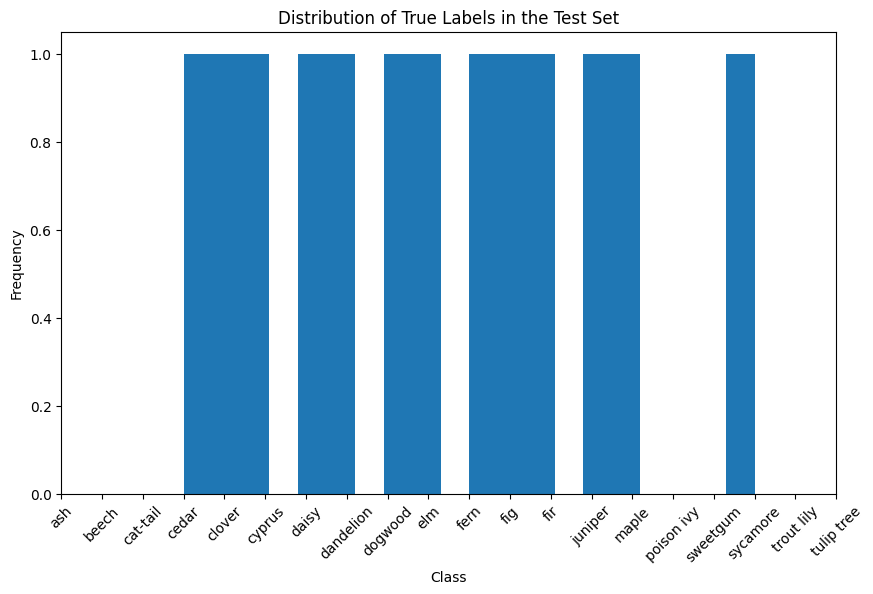

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(ground_truth_labels, bins=len(class_names))
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Distribution of True Labels in the Test Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Extract features from images using the trained CNN
train_features = model.predict(train_data_gen)
val_features = model.predict(val_data_gen)

71/71 [==============================] - 265s 4s/step


In [ ]:
# Assuming val_features has shape (1, num_samples, height, width, channels)
val_features = np.squeeze(val_features, axis=0)

In [ ]:
val_features = model.predict(val_data_gen)

71/71 [==============================] - 274s 4s/step


In [ ]:
# Extract labels from the training data generator
train_labels = list(train_data_gen.class_indices.keys())
print(train_labels)

['ash', 'beech', 'cattail', 'cedar', 'clover', 'cyprus', 'daisy', 'dandelion', 'dogwood', 'elm', 'fern', 'fig', 'fir', 'juniper', 'maple', 'poison_ivy', 'sweetgum', 'sycamore', 'trout_lily', 'tulip_tree']


In [ ]:
# Convert one-hot encoded labels to class indices
val_labels = val_data_gen.classes

<ipython-input-91-7f885dc65277>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


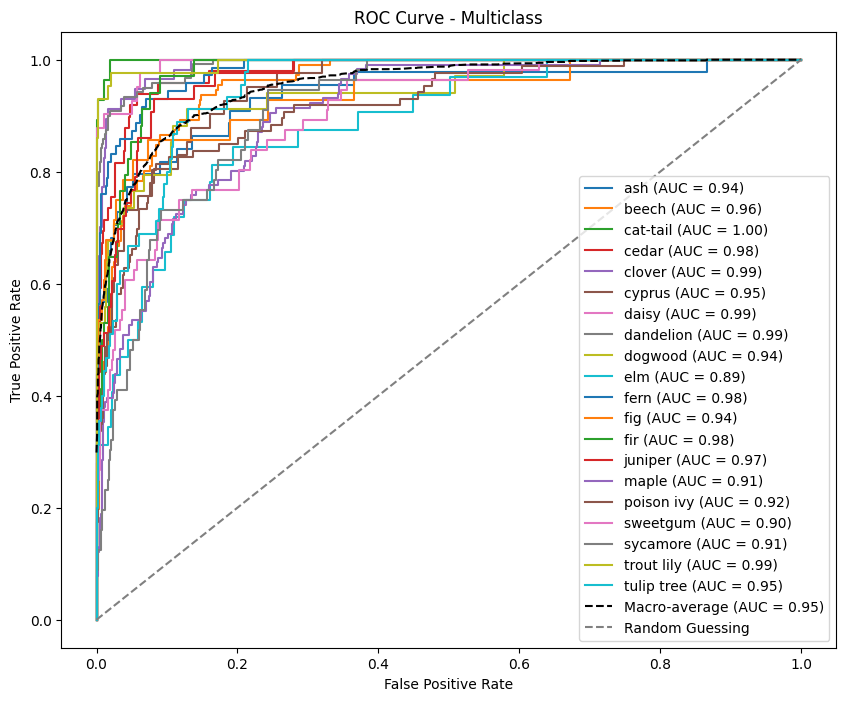

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Assuming val_features has shape (num_samples, num_classes)
# and val_labels has shape (num_samples,)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels, val_features[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC over all classes
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curve for each class and the macro-average
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', linestyle='--', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend()
plt.show()

1/1 [==============================] - 0s 304ms/step


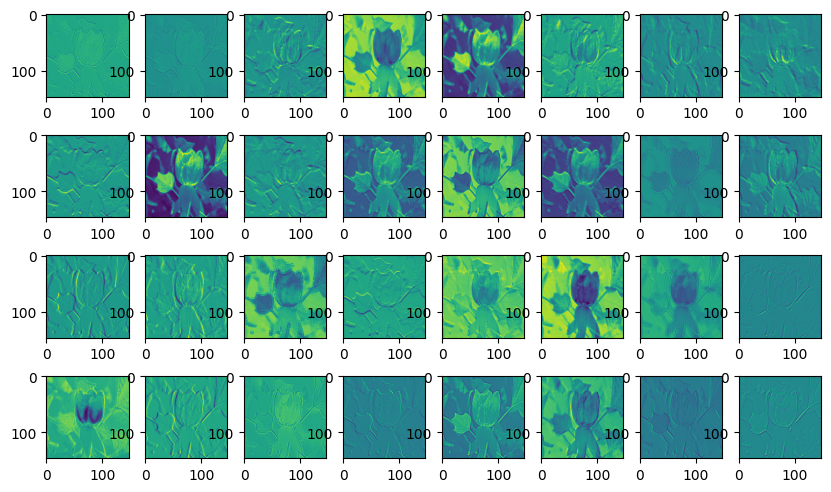

In [ ]:
# Define activation model to extract activations from intermediate layers
activation_model = Model(inputs=model.input, outputs=model.layers[5].output)
# Change the index to visualize activations from different layers
sample_img = load_img('/content/PlantCLEF_Subset/test/daisy.jpg', target_size=(img_height, img_width))
sample_img_array = img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
activations = activation_model.predict(sample_img_array)

# Plot activation maps
plt.figure(figsize=(10, 6))
for i in range(32):  # Change the range to visualize different activation maps
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
plt.show()


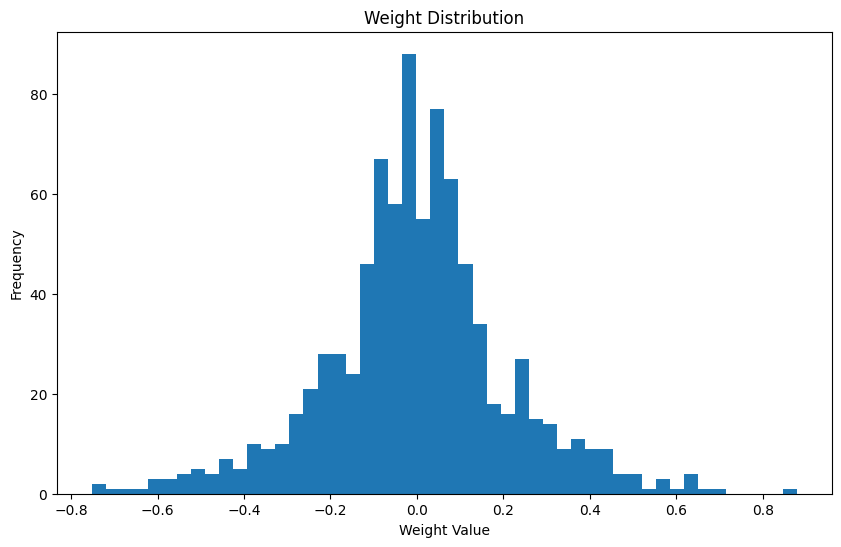

In [ ]:
# Get model weights
weights = model.get_weights()

# Plot weight distribution
plt.figure(figsize=(10, 6))
plt.hist(weights[0].flatten(), bins=50)  # Change the index to visualize weights from different layers
plt.title('Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()


71/71 [==============================] - 32s 438ms/step


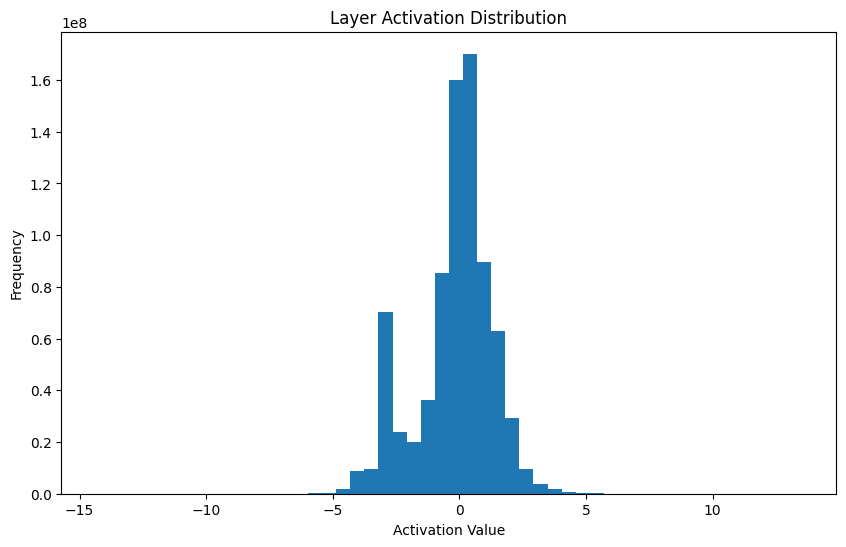

In [ ]:
# Extract activations from intermediate layers
activation_model = Model(inputs=model.input, outputs=model.layers[5].output) # Change the index to visualize activations from different layers
activations = activation_model.predict(val_data_gen)

# Plot activation distribution
plt.figure(figsize=(10, 6))
plt.hist(activations.flatten(), bins=50)
plt.title('Layer Activation Distribution')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Display model architecture summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

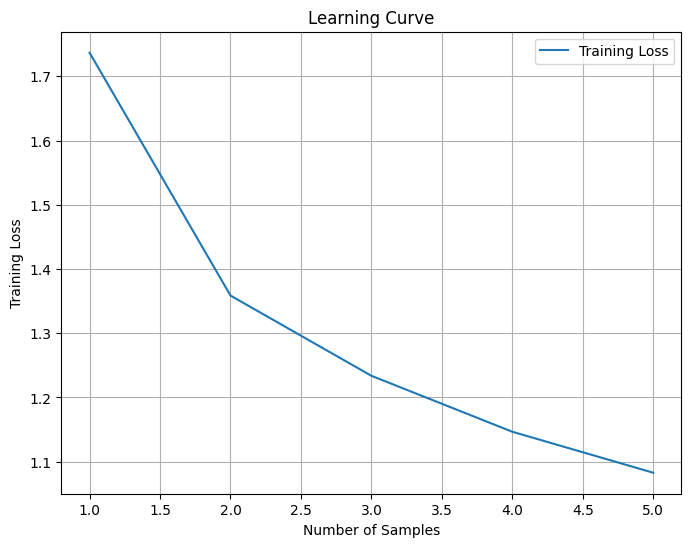

In [ ]:
num_samples = np.arange(1, len(history.history['loss']) + 1)
plt.figure(figsize=(8, 6))
plt.plot(num_samples, history.history['loss'], label='Training Loss')
plt.xlabel('Number of Samples')
plt.ylabel('Training Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 117ms/step


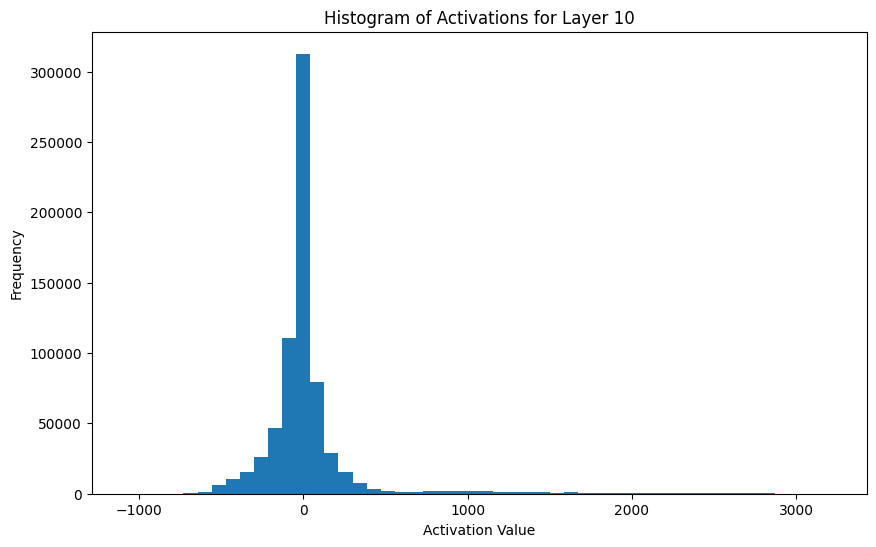

In [ ]:
layer_index = 10  # Specify the index of the layer
activations = activation_model.predict(sample_img_array)
plt.figure(figsize=(10, 6))
plt.hist(activations.flatten(), bins=50)
plt.title(f'Histogram of Activations for Layer {layer_index}')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()


1/1 [==============================] - 0s 39ms/step


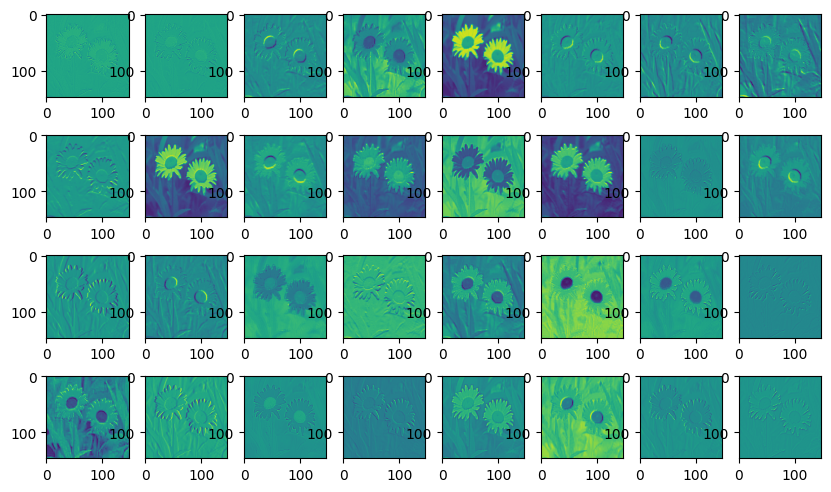

In [ ]:
sample_img = load_img('/content/PlantCLEF_Subset/test/daisy.jpg', target_size=(img_height, img_width))
sample_img_array = img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
activations = activation_model.predict(sample_img_array)

plt.figure(figsize=(10, 6))
for i in range(32): # Change the range to visualize different feature maps
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
plt.show()


1/1 [==============================] - 0s 39ms/step


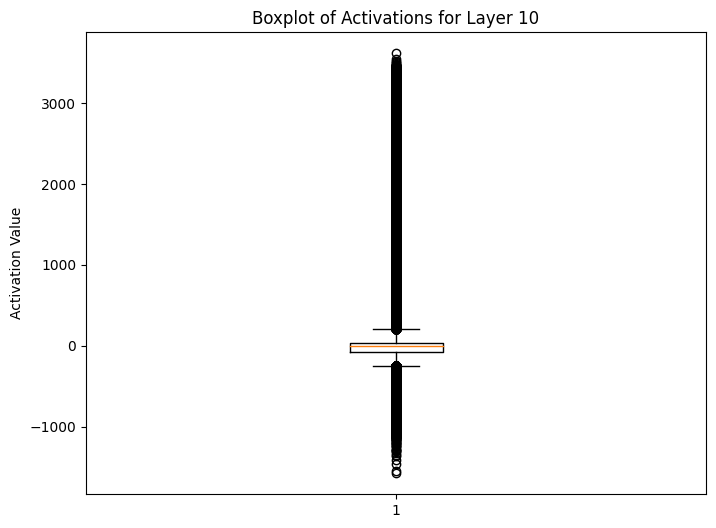

In [ ]:
layer_index = 10  # Specify the index of the layer
activations = activation_model.predict(sample_img_array)

plt.figure(figsize=(8, 6))
plt.boxplot(activations.reshape(-1, 1))
plt.title(f'Boxplot of Activations for Layer {layer_index}')
plt.ylabel('Activation Value')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

test_predictions_array = np.array(test_predictions)
print("Shape of test_predictions_array:", test_predictions_array.shape)


Shape of test_predictions_array: (30,)


In [ ]:
print("Size of true_probabilities:", len(true_probabilities))
print("Size of test_predictions_array:", len(test_predictions_array))


Size of true_probabilities: 13
Size of test_predictions_array: 30


In [ ]:
sorted_probabilities = np.sort(np.max(predicted_probabilities, axis=1))
cumulative_probabilities = np.arange(1, len(sorted_probabilities) + 1) / len(sorted_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(sorted_probabilities, cumulative_probabilities, marker='.')
plt.title('Cumulative Distribution of Predicted Probabilities')
plt.xlabel('Maximum Predicted Probability')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()


NameError: name 'predicted_probabilities' is not defined

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(np.concatenate((train_features, val_features)), np.concatenate((train_data_gen.classes, val_data_gen.classes)))

# Make predictions on validation or test set
svm_predictions = svm_classifier.predict(val_features)
# Convert one-hot encoded labels to class indices
val_labels = val_data_gen.classes

# Calculate evaluation metrics
svm_accuracy = accuracy_score(val_labels, svm_predictions)
svm_precision = precision_score(val_labels, svm_predictions, average='weighted')
svm_recall = recall_score(val_labels, svm_predictions, average='weighted')
svm_f1_score = f1_score(val_labels, svm_predictions, average='weighted')

print("SVM Classifier Metrics:")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"F1-Score: {svm_f1_score}")


SVM Classifier Metrics:
Accuracy: 0.42555066079295156
Precision: 0.31817851006162695
Recall: 0.42555066079295156
F1-Score: 0.33900071542056565


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Create an instance of the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier
knn_classifier.fit(train_features, train_data_gen.classes)

# Evaluate the KNN classifier on the validation set
val_predictions = knn_classifier.predict(val_features)

# Evaluate the performance of the KNN classifier
print("KNN Classifier Evaluation Metrics:")
print("Accuracy:", accuracy_score(val_data_gen.classes, val_predictions))
print("Classification Report:")
print(classification_report(val_data_gen.classes, val_predictions, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(val_data_gen.classes, val_predictions))

KNN Classifier Evaluation Metrics:
Accuracy: 0.06255506607929516
Classification Report:
              precision    recall  f1-score   support

         ash       0.04      0.11      0.06        44
       beech       0.07      0.18      0.10       111
    cat-tail       0.04      0.07      0.05        28
       cedar       0.01      0.02      0.02        49
      clover       0.08      0.12      0.10        57
      cyprus       0.05      0.05      0.05        41
       daisy       0.00      0.00      0.00        41
   dandelion       0.09      0.09      0.09       120
     dogwood       0.06      0.03      0.04        34
         elm       0.00      0.00      0.00        32
        fern       0.05      0.03      0.04        71
         fig       0.00      0.00      0.00        28
         fir       0.00      0.00      0.00        34
     juniper       0.00      0.00      0.00        43
       maple       0.15      0.10      0.12       116
  poison ivy       0.08      0.05      0.06    